# Matriz Orígen Destino a partir de los datos de Twitter

In [1]:
%load_ext autoreload
%autoreload 2
import geopandas as gpd
from shapely.geometry import LineString, Point
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import contextily as ctx

## Leer los tuits

Para probar y hacer todo más rápido, vamos a usar sólo una muestra de 1M al azar

In [2]:
tuits = gpd.read_file("../output/tuits_2018.gpkg")
tuits = tuits.sample(n=1000000)
tuits.head()

,ID,Usuario,Fecha_tweet,Distrito,fecha_hora_dt,geometry
5676021,1025397992143167488,caballerobeto,2018-08-03T15:08:26.000Z,003,2018-08-03T15:08:26+00:00,POINT (-99.12789 19.44633)
2916136,956012049162579968,Gercektravel,2018-01-24T03:53:29.000Z,115,2018-01-24T03:53:29+00:00,POINT (-99.16428 19.54393)
888632,1074456720183881728,AlfredoMungui12,2018-12-17T00:10:19.000Z,139,2018-12-17T00:10:19+00:00,POINT (-99.11589 19.51866)
2387835,1044030120997007360,JIvanLpez1,2018-09-24T01:05:52.000Z,034,2018-09-24T01:05:52+00:00,POINT (-99.08782 19.43208)
2301272,1045356239893475328,rincondedacne,2018-09-27T16:55:24.000Z,002,2018-09-27T16:55:24+00:00,POINT (-99.15337 19.43284)


Transformamos `fecha_hora_dt` en datetime

In [8]:
tuits.fecha_hora_dt = pd.to_datetime(
        tuits['fecha_hora_dt'],
        format='%Y-%m-%d %H:%M:%S',
        utc=True)
tuits.head()

,ID,Usuario,Fecha_tweet,Distrito,fecha_hora_dt,geometry
5676021,1025397992143167488,caballerobeto,2018-08-03T15:08:26.000Z,003,2018-08-03 15:08:26+00:00,POINT (-99.12789 19.44633)
2916136,956012049162579968,Gercektravel,2018-01-24T03:53:29.000Z,115,2018-01-24 03:53:29+00:00,POINT (-99.16428 19.54393)
888632,1074456720183881728,AlfredoMungui12,2018-12-17T00:10:19.000Z,139,2018-12-17 00:10:19+00:00,POINT (-99.11589 19.51866)
2387835,1044030120997007360,JIvanLpez1,2018-09-24T01:05:52.000Z,034,2018-09-24 01:05:52+00:00,POINT (-99.08782 19.43208)
2301272,1045356239893475328,rincondedacne,2018-09-27T16:55:24.000Z,002,2018-09-27 16:55:24+00:00,POINT (-99.15337 19.43284)


## Obtener las trayectorias

Vamos a agrupar por dia y por intervalos de 3 horas como base temporal para calcular la matriz OD.

Para poder encontrar las trayectorias de los usuarios, necesitamos también agrupar por `uname`

Para entender bien la agrupación, vamos primero a seleccionar un sólo dia


**NOTA:** Hay que separar dias hábiles

### Agrupación de datos

Vamos a empezar por ver cómo funciona la agrupación para un sólo dia

In [16]:
un_dia = (tuits.groupby([pd.Grouper(key='fecha_hora_dt', freq='1D'), 
                pd.Grouper(key='fecha_hora_dt', freq='4H', base=2), 
                'Usuario'])
       .count().loc['2018-05-25 00:00:00+00:00',:,:])
un_dia.index.names =['dia', 'intervalo', 'uname']
un_dia.head()

ID  \
dia                       intervalo                 uname                 
2018-05-25 00:00:00+00:00 2018-05-24 22:00:00+00:00 190591Dafne       1   
                                                    1988JesusChrist   1   
                                                    79Wen             1   
                                                    88ARELU           1   
                                                    ARES8269          1   

                                                                     Fecha_tweet  \
dia                       intervalo                 uname                          
2018-05-25 00:00:00+00:00 2018-05-24 22:00:00+00:00 190591Dafne                1   
                                                    1988JesusChrist            1   
                                                    79Wen                      1   
                                                    88ARELU                    1   
                                                    ARES8269                   1   

                                                                     Distrito  \
dia                       intervalo                 uname                       
2018-05-25 00:00:00+00:00 2018-05-24 22:00:00+00:00 190591Dafne             1   
                                                    1988JesusChrist         1   
                                                    79Wen                   1   
                                                    88ARELU                 1   
                                                    ARES8269                1   

                                                                     geometry  
dia                       intervalo                 uname                      
2018-05-25 00:00:00+00:00 2018-05-24 22:00:00+00:00 190591Dafne             1  
                                                    1988JesusChrist         1  
                                                    79Wen                   1  
                                                    88ARELU                 1  
                                                    ARES8269                1

In [117]:
un_dia.reset_index().dia.unique()

<DatetimeArray>
['2014-11-26 00:00:00-06:00']
Length: 1, dtype: datetime64[ns, America/Mexico_City]

In [17]:
sorted(list(un_dia.reset_index().intervalo.unique()))

[Timestamp('2018-05-24 22:00:00+0000', tz='UTC'),
 Timestamp('2018-05-25 02:00:00+0000', tz='UTC'),
 Timestamp('2018-05-25 06:00:00+0000', tz='UTC'),
 Timestamp('2018-05-25 10:00:00+0000', tz='UTC'),
 Timestamp('2018-05-25 14:00:00+0000', tz='UTC'),
 Timestamp('2018-05-25 18:00:00+0000', tz='UTC'),
 Timestamp('2018-05-25 22:00:00+0000', tz='UTC')]

En efecto, podemos seleccionar un dia, los intervalos están bien, por ejemplo toman de las 6 a las 10 de la mañana y eso nos gusta para capturar los viajes del inicio del dia laboral. Lo que está raro es el primer intervalo, que toma de las 10 de la noche del dia anterior a las dos de la mañana del dia actual (por lo mismo, el último, abarca hasta las dos de la mañana del dia siguiente). Vamos a inspeccionar entonces el dia previo

In [18]:
anterior = (tuits.groupby([pd.Grouper(key='fecha_hora_dt', freq='1D'), 
                pd.Grouper(key='fecha_hora_dt', freq='4H', base=2), 
                'Usuario'])
       .count().loc['2018-05-24 00:00:00+00:00',:,:])
anterior.index.names =['dia', 'intervalo', 'uname']
sorted(list(anterior.reset_index().intervalo.unique()))

[Timestamp('2018-05-23 22:00:00+0000', tz='UTC'),
 Timestamp('2018-05-24 02:00:00+0000', tz='UTC'),
 Timestamp('2018-05-24 06:00:00+0000', tz='UTC'),
 Timestamp('2018-05-24 10:00:00+0000', tz='UTC'),
 Timestamp('2018-05-24 14:00:00+0000', tz='UTC'),
 Timestamp('2018-05-24 18:00:00+0000', tz='UTC'),
 Timestamp('2018-05-24 22:00:00+0000', tz='UTC')]

El primer intervalo del día anterior y el último de este son aparentemente iguales, empiezan a las 22:00 del 2018-05-24. Vamos a verlos 

In [27]:
agrupacion = (tuits.groupby([pd.Grouper(key='fecha_hora_dt', freq='1D'), 
                pd.Grouper(key='fecha_hora_dt', freq='4H', base=2), 
                'Usuario'])
               .count())
del_25 = agrupacion.loc['2018-05-24 00:00:00+00:00','2018-05-24 22:00:00+0000',:]
del_26 = agrupacion.loc['2018-05-25 00:00:00+00:00','2018-05-25 22:00:00+00:00',:]

In [24]:
del_25.sort_index(level='Usuario').head()

ID  \
fecha_hora_dt             fecha_hora_dt             Usuario              
2018-05-24 00:00:00+00:00 2018-05-24 22:00:00+00:00 02Irene          1   
                                                    1Cristiandeath   1   
                                                    ALASDELALMARB    1   
                                                    AManriquezM      1   
                                                    AUREAZAPATA      1   

                                                                    Fecha_tweet  \
fecha_hora_dt             fecha_hora_dt             Usuario                       
2018-05-24 00:00:00+00:00 2018-05-24 22:00:00+00:00 02Irene                   1   
                                                    1Cristiandeath            1   
                                                    ALASDELALMARB             1   
                                                    AManriquezM               1   
                                                    AUREAZAPATA               1   

                                                                    Distrito  \
fecha_hora_dt             fecha_hora_dt             Usuario                    
2018-05-24 00:00:00+00:00 2018-05-24 22:00:00+00:00 02Irene                1   
                                                    1Cristiandeath         1   
                                                    ALASDELALMARB          1   
                                                    AManriquezM            1   
                                                    AUREAZAPATA            1   

                                                                    geometry  
fecha_hora_dt             fecha_hora_dt             Usuario                   
2018-05-24 00:00:00+00:00 2018-05-24 22:00:00+00:00 02Irene                1  
                                                    1Cristiandeath         1  
                                                    ALASDELALMARB          1  
                                                    AManriquezM            1  
                                                    AUREAZAPATA            1

In [28]:
del_26.sort_index(level='Usuario').head()

ID  \
fecha_hora_dt             fecha_hora_dt             Usuario               
2018-05-25 00:00:00+00:00 2018-05-25 22:00:00+00:00 05Cesgar          1   
                                                    6SRocketman       1   
                                                    AdaMarinaGamaB    1   
                                                    Adancervantes69   1   
                                                    AdelangelAdn      1   

                                                                     Fecha_tweet  \
fecha_hora_dt             fecha_hora_dt             Usuario                        
2018-05-25 00:00:00+00:00 2018-05-25 22:00:00+00:00 05Cesgar                   1   
                                                    6SRocketman                1   
                                                    AdaMarinaGamaB             1   
                                                    Adancervantes69            1   
                                                    AdelangelAdn               1   

                                                                     Distrito  \
fecha_hora_dt             fecha_hora_dt             Usuario                     
2018-05-25 00:00:00+00:00 2018-05-25 22:00:00+00:00 05Cesgar                1   
                                                    6SRocketman             1   
                                                    AdaMarinaGamaB          1   
                                                    Adancervantes69         1   
                                                    AdelangelAdn            1   

                                                                     geometry  
fecha_hora_dt             fecha_hora_dt             Usuario                    
2018-05-25 00:00:00+00:00 2018-05-25 22:00:00+00:00 05Cesgar                1  
                                                    6SRocketman             1  
                                                    AdaMarinaGamaB          1  
                                                    Adancervantes69         1  
                                                    AdelangelAdn            1

In [29]:
print(del_26['ID'].sum(), del_25['ID'].sum())

266 269


Son realmente intervalos distintos. Pandas no está sobrelapando los intervalos, más bien sólo desplaza el origen cuando hacemos `d.Grouper(key='fecha_hora_dt', freq='4H', base=2)`. Entonces podemos continuar a calcular las trayectorias

### Trayectorias

En principio, sólo tenemos que pasar una función que regrese un `LineString` para cada uno de los grupos, pero tenemos que asegurarnos de que nuestros datos están ordenados por hora. Para eso usamos la función `sort_index()`

In [30]:
tuits.sort_index(inplace=True)

Ahora sólo tenemos que escribir una función que agregue nuestros grupos y nos regrese lo que queremos. Es decir, que tome cada grupo por dia y por usuario y, para aquellos grupos que tengan más de un punto, regrese el `LineString`.

Lo que necesitamos saber es que cada grupo es internamente una serie, entonces es fácil saber su tamaño y aplicarle cualquier función dependiendo de él.

In [31]:
def regresa_puntos(s):
  if s.size > 1:
    return s.tolist()
trayectorias = (tuits.groupby([pd.Grouper(key='fecha_hora_dt', freq='1D'), 
                pd.Grouper(key='fecha_hora_dt', freq='4H', base=2), 
                'Usuario']))[['geometry']].agg(regresa_puntos)
trayectorias.index.names =['dia', 'intervalo', 'Usuario']
trayectorias = trayectorias[trayectorias['geometry'].notnull()]
trayectorias.head()

geometry
dia                       intervalo                 Usuario                                                           
2018-01-01 00:00:00+00:00 2017-12-31 22:00:00+00:00 AnayPanchochis   [POINT (-98.9903395 19.7051795), POINT (-98.99...
                                                    GennyOdette      [POINT (-99.2115105 19.4299345), POINT (-99.21...
                                                    LuisDarioGarcia  [POINT (-99.0170165 19.432722), POINT (-99.017...
                                                    Mauvegaam        [POINT (-99.15336600000001 19.432836), POINT (...
                                                    OVIALCDMX        [POINT (-99.15336600000001 19.432836), POINT (...

Convertimos las trayectorias a líneas

In [32]:
trayectorias['linea'] = trayectorias['geometry'].apply(lambda x: LineString(x))
trayectorias.head()

geometry  \
dia                       intervalo                 Usuario                                                              
2018-01-01 00:00:00+00:00 2017-12-31 22:00:00+00:00 AnayPanchochis   [POINT (-98.9903395 19.7051795), POINT (-98.99...   
                                                    GennyOdette      [POINT (-99.2115105 19.4299345), POINT (-99.21...   
                                                    LuisDarioGarcia  [POINT (-99.0170165 19.432722), POINT (-99.017...   
                                                    Mauvegaam        [POINT (-99.15336600000001 19.432836), POINT (...   
                                                    OVIALCDMX        [POINT (-99.15336600000001 19.432836), POINT (...   

                                                                                                                 linea  
dia                       intervalo                 Usuario                                                             
2018-01-01 00:00:00+00:00 2017-12-31 22:00:00+00:00 AnayPanchochis   LINESTRING (-98.9903395 19.7051795, -98.990339...  
                                                    GennyOdette      LINESTRING (-99.2115105 19.4299345, -99.211510...  
                                                    LuisDarioGarcia  LINESTRING (-99.0170165 19.432722, -99.0170165...  
                                                    Mauvegaam        LINESTRING (-99.15336600000001 19.432836, -99....  
                                                    OVIALCDMX        LINESTRING (-99.15336600000001 19.432836, -99....

Eliminamos la columna con la lista de puntos, renombramos la columna `linea` a `geometry` y convertimos todo en `GeoDataFrame`

In [33]:
trayectorias.drop(['geometry'], axis=1, inplace=True)
trayectorias.rename({'linea': 'geometry'}, axis=1, inplace=True)
trayectorias = gpd.GeoDataFrame(trayectorias)
trayectorias.head()

geometry
dia                       intervalo                 Usuario                                                           
2018-01-01 00:00:00+00:00 2017-12-31 22:00:00+00:00 AnayPanchochis   LINESTRING (-98.99034 19.70518, -98.99034 19.7...
                                                    GennyOdette      LINESTRING (-99.21151 19.42993, -99.21151 19.4...
                                                    LuisDarioGarcia  LINESTRING (-99.01702 19.43272, -99.01702 19.4...
                                                    Mauvegaam        LINESTRING (-99.15337 19.43284, -99.15337 19.4...
                                                    OVIALCDMX        LINESTRING (-99.15337 19.43284, -99.15337 19.4...

In [44]:
trayectorias = trayectorias.set_crs(epsg=4326)

Podemos tomar un dia y ponerlo en el mapa sobre las zonas de análisis

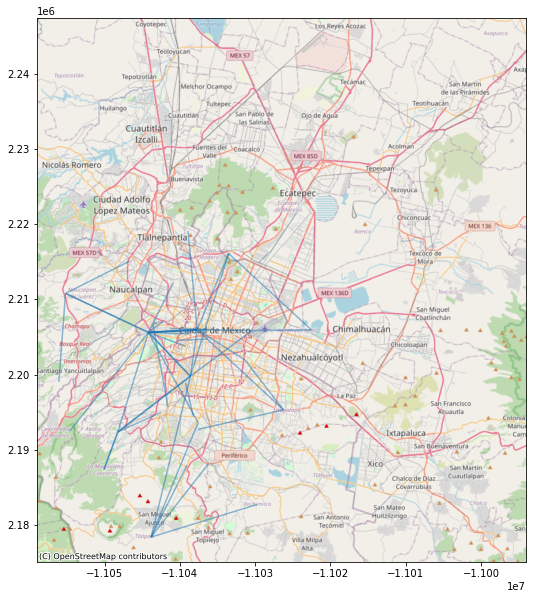

In [45]:
fig , ax = plt.subplots(1, figsize=(15,10))
#zonas.plot(ax=ax, facecolor='grey', alpha=0.8)
trayectorias.loc['2018-05-24 00:00:00','2018-05-23 06:00:00+00:00':].to_crs(epsg=3857).plot(ax=ax, alpha=0.5)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

Perfecto, son pocas líneas, pero es normal, es sólo un dia y de una muestra de los tuits. No todas las trayectorias van a representar a alguien yendo de un lugar a otro. Una persona sentada en su casa mandando varios tuits mientras ve la tele, también representa una trayectoria , pero esa no la queremos. Tenemos dos opciones para filtrar: por la longitud de la rayectoria o por la separación de sus puntos inicial y final. Como estamos queriendo capturar gente que _se mueve_, creo que es mejor elegir la segunda opción.

Entonces, vamos a agragar una columna con la distancia entre el inicio y fin de las trayectorias.

In [46]:
def get_start_end_distance(line):
  start = Point(line.coords[0])
  end = Point(line.coords[-1])
  return start.distance(end)

trayectorias['separation'] = trayectorias['geometry'].apply(get_start_end_distance)
trayectorias.head()

geometry  \
dia                       intervalo                 Usuario                                                              
2018-01-01 00:00:00+00:00 2017-12-31 22:00:00+00:00 AnayPanchochis   LINESTRING (-98.99034 19.70518, -98.99034 19.7...   
                                                    GennyOdette      LINESTRING (-99.21151 19.42993, -99.21151 19.4...   
                                                    LuisDarioGarcia  LINESTRING (-99.01702 19.43272, -99.01702 19.4...   
                                                    Mauvegaam        LINESTRING (-99.15337 19.43284, -99.15337 19.4...   
                                                    OVIALCDMX        LINESTRING (-99.15337 19.43284, -99.15337 19.4...   

                                                                     separation  
dia                       intervalo                 Usuario                      
2018-01-01 00:00:00+00:00 2017-12-31 22:00:00+00:00 AnayPanchochis          0.0  
                                                    GennyOdette             0.0  
                                                    LuisDarioGarcia         0.0  
                                                    Mauvegaam               0.0  
                                                    OVIALCDMX               0.0

Ahora necesitamos escoger una separación mínima para las trayectorias que vamos a considerar. De alguna forma este límite es arbitrario, pero es la distancia mínima entre origen y destino para que consideremos al movimiento como un viaje. Pensemos por lo pronto que sean 300m

In [47]:
trayectorias_filtradas = trayectorias[trayectorias['separation'] >= 300]
print(trayectorias_filtradas.shape[0], trayectorias.shape[0])

0 95771


Terminamos con una muestra de  12,588 viajes para todo el periodo. Ahora podemos entonces calcular la matriz Origen destino

## Automatización

Todo este flujo está _empaquetado_ en la función `get_trayectories` que se puede utilizar así:

In [49]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.preprocess import get_trayectories
tuits_path = "../output/tuits_2018.gpkg"
trayectorias = get_trayectories(tuits_path, 300)
trayectorias.head()

geometry  \
dia                       intervalo                 Usuario                                                           
2018-01-01 00:00:00+00:00 2017-12-31 22:00:00+00:00 2Rene1982     LINESTRING (486006.893 2148777.685, 490781.385...   
                                                    AdryLATREVI   LINESTRING (482869.514 2147672.967, 486107.871...   
                                                    BoogeymanMX   LINESTRING (490531.670 2170098.393, 486303.994...   
                                                    Calcifer_May  LINESTRING (486006.893 2148777.685, 486107.871...   
                                                    ChalArauz     LINESTRING (487840.819 2158221.322, 486714.205...   

                                                                   separation  
dia                       intervalo                 Usuario                    
2018-01-01 00:00:00+00:00 2017-12-31 22:00:00+00:00 2Rene1982     4776.501901  
                                                    AdryLATREVI   9317.335796  
                                                    BoogeymanMX   4253.572117  
                                                    Calcifer_May  9841.699738  
                                                    ChalArauz     2779.291581

Sólo para estar seguros, repitamos el mapa

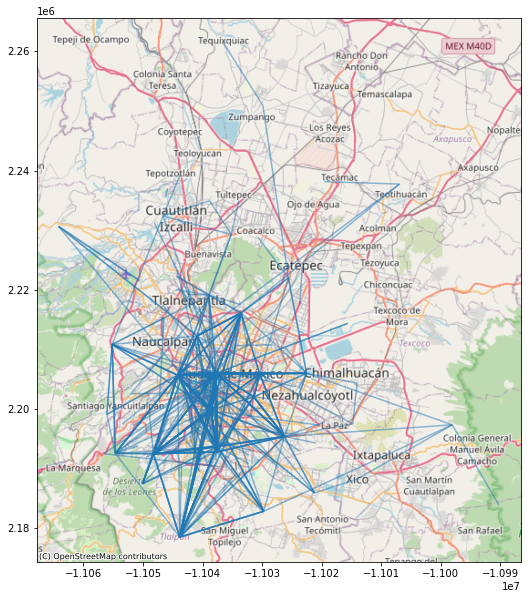

In [50]:
fig , ax = plt.subplots(1, figsize=(15,10))
#zonas.plot(ax=ax, facecolor='grey', alpha=0.8)
trayectorias.loc['2018-05-24 00:00:00','2018-05-23 06:00:00+00:00':].to_crs(epsg=3857).plot(ax=ax, alpha=0.5)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

Guardamos los datos, para no tener que volverlo a correr

In [51]:
trayectorias.to_file("../output/trayectorias_2018.gpkg", layer='trayectorias', driver="GPKG")